# OptaPy - Tractor Routing

## Tractor Routing Quickstart

### Model the domain objects and constraints

Using a fleet of tractor, treat each field and get back to the barn. Each tractor can treat multiple fields, but it has a limited capacity.

#### Problem Facts

Problem facts are facts about the problem. As such, they do not change during solving (and thus cannot have any planning variables). For Tractor Routing, the problem facts are the locations a tractor can visit, the barns, and the fields to visit:

In [1]:
# Install requirements
!pip install -qr requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
class Location:
    def __init__(self, X, Y, distance_map=None):
        self.X = X
        self.Y = Y
        self.distance_map = distance_map

    def set_distance_map(self, distance_map):
        self.distance_map = distance_map

    def get_distance_to(self, location):
        return self.distance_map[location]

    def to_X_Y_tuple(self):
        return (
            self.X,
            self.Y
        )

    def __str__(self):
        return f'[{self.X}, {self.Y}]'


A location is composed of its coordinates. Its distance to other locations is stored in a distance map, which is populated by a distance calculator:

In [3]:
import math


class EuclideanDistanceCalculator:
    def __init__(self):
        pass

    def calculate_distance(self, start, end):
        if start == end:
            return 0
        X_diff = end.X - start.X
        Y_diff = end.Y - start.Y
        return math.ceil(math.sqrt(X_diff**2 + Y_diff**2))

    def init_distance_maps(self, location_list):
        for location in location_list:
            distance_map = dict()
            for other_location in location_list:
                distance_map[other_location] = self.calculate_distance(location, other_location)
            location.set_distance_map(distance_map)

A tractor departs and comes back to a specific barn to reload:

In [4]:
class Barn:
    def __init__(self, name, location):
        self.name = name
        self.location = location

    def __str__(self):
        return f'BarnLocation {self.name}'

A tractor visits fields to treat crops, which take up some capacity of the tractor:

In [5]:
from optapy import problem_fact


@problem_fact
class Field:
    def __init__(self, name, location, demand):
        self.name = name
        self.location = location
        self.demand = demand

    def __str__(self):
        return f'Field {self.name}'

---
**NOTE**

You may have noticed none of the problem fact classes are decorated with `@problem_fact`. That is because they are not referenced directly in constraints, but accessed indirectly via the Tractor class.

---

#### Planning Entities

In Tractor Routing, tractors are the planning entities. Each tractor has a fixed barn to depart from and return to, and a list of fields to visit which we want to plan. In particular:

- A field is visited by exactly one tractor
- The order of the field in the list is significant

as such, the field list can be modelled as a planning list variable:

In [6]:
from optapy import planning_entity, planning_list_variable


@planning_entity
class Tractor:
    def __init__(self, name, capacity, barn, field_list=None):
        self.name = name
        self.capacity = capacity
        self.barn = barn
        if field_list is None:
            self.field_list = []
        else:
            self.field_list = field_list

    @planning_list_variable(Field, ['field_range'])
    def get_field_list(self):
        return self.field_list

    def set_field_list(self, field_list):
        self.field_list = field_list

    def get_route(self):
        if len(self.field_list) == 0:
            return []
        route = [self.barn.location]
        for field in self.field_list:
            route.append(field.location)
        route.append(self.barn.location)
        return route

    def __str__(self):
        return f'Tractor {self.name}'

The `@planning_list_variable` decorator tells OptaPy the method is a getter for a planning list variable. It takes two parameters:

- The first parameter is the type this planning variable takes.
- The second parameter, `value_range_provider_refs`, describes where it gets its values from.
  It a list of the id of its value range providers. This is defined later in the `@planning_solution` class.


#### The Constraints

In tractor routing, we have one hard constraint: no tractor can go over its capacity

In [7]:
from optapy.score import HardSoftScore


def get_total_demand(tractor):
    total_demand = 0
    for field in tractor.field_list:
        total_demand += field.demand
    return total_demand

def tractor_capacity(constraint_factory):
    return constraint_factory \
        .for_each(Tractor) \
        .filter(lambda tractor: get_total_demand(tractor) > tractor.capacity) \
        .penalize("Over tractor capacity", HardSoftScore.ONE_HARD,
                  lambda tractor: int(get_total_demand(tractor) - tractor.capacity))

The lambda in penalize controls how much to penalize for a violation. We want a tractor 5 over capacity to be penalized more than a tractor only 1 over capacity. Hence we penalize by

`get_total_demand(tractor) - tractor.capacity`

which is how much over capacity the tractor is.

We also have one soft constraint: minimize the total distance

In [8]:
def get_total_distance(tractor):
    total_distance = 1
    last_location = tractor.barn.location
    for field in tractor.field_list:
        total_distance += field.location.get_distance_to(last_location)
        last_location = field.location
    if last_location is not tractor.barn.location:
        total_distance += tractor.barn.location.get_distance_to(last_location)
    return total_distance


def total_distance(constraint_factory):
    return constraint_factory \
        .for_each(Tractor) \
        .penalize("Minimize total distance", HardSoftScore.ONE_SOFT,
                  lambda tractor: int(get_total_distance(tractor)))

Every initialized Tractor is penalized in the constraint, since we want to minimalize total distance.

Return a list containing the constraints in a `@constraint_provider` decorated function:

In [9]:
from optapy import constraint_provider


@constraint_provider
def tractor_routing_constraints(constraint_factory):
    return [
        # Hard constraints
        tractor_capacity(constraint_factory),

        # Soft constraints
        total_distance(constraint_factory)
    ]

#### Planning Solution

Finally, there is the planning solution. The planning solution stores references to all the problem facts and planning entities that define the problem. Additionally, it also contain the score of the solution. The planning solution class represent both the problem and the solution; as such, a problem can be viewed as an uninitialized planning solution.

In Tractor Routing, it needs to contain the field list, tractor list, and the score. The bounds are included for easier visualization of the route:

In [10]:
from optapy import planning_solution, planning_entity_collection_property, problem_fact_collection_property, \
    value_range_provider, planning_score


@planning_solution
class TractorRoutingSolution:
    def __init__(self,  name, location_list, barn_list, tractor_list, field_list,
                 south_west_corner, north_east_corner, score=None):
        self.name = name
        self.location_list = location_list
        self.barn_list = barn_list
        self.tractor_list = tractor_list
        self.field_list = field_list
        self.south_west_corner = south_west_corner
        self.north_east_corner = north_east_corner
        self.score = score

    @planning_entity_collection_property(Tractor)
    def get_tractor_list(self):
        return self.tractor_list

    @problem_fact_collection_property(Field)
    @value_range_provider('field_range', value_range_type=list)
    def get_field_list(self):
        return self.field_list

    @planning_score(HardSoftScore)
    def get_score(self):
        return self.score

    def set_score(self, score):
        self.score = score

    def get_bounds(self):
        return [self.south_west_corner.to_X_Y_tuple(), self.north_east_corner.to_X_Y_tuple()]

    def get_distance_meters(self):
        return -self.score.getSoftScore() if self.score is not None else 0

### Solving

Now that we defined our model and constraints, let create an instance of the problem:

In [11]:
from data import DataBuilder

problem = DataBuilder.builder(Location, Barn, Field, Tractor, TractorRoutingSolution, 
                              EuclideanDistanceCalculator()) \
                             .set_tractor_capacity(2) \
                             .set_field_count(50).set_tractor_count(15).set_barn_count(1) \
                             .set_south_west_corner(Location(0, 1079)) \
                             .set_north_east_corner(Location(1919, 0)).build()

and solve it:

In [12]:
from optapy import solver_manager_create
import optapy.config
from optapy.types import Duration

SINGLETON_ID = 1
solver_config = optapy.config.solver.SolverConfig()
solver_config \
    .withSolutionClass(TractorRoutingSolution) \
    .withEntityClasses(Tractor) \
    .withConstraintProviderClass(tractor_routing_constraints) \
    .withTerminationSpentLimit(Duration.ofSeconds(30))

solver_manager = solver_manager_create(solver_config)
last_score = HardSoftScore.ZERO

tractor_routing_solution = problem

In [13]:
best_solution = solver_manager.solve(SINGLETON_ID, lambda _: problem)
final_solution = best_solution.getFinalBestSolution()

14:25:34.524 [l-1-thread-1] INFO  Solving started: time spent (126), best score (-50init/0hard/-15soft), environment mode (REPRODUCIBLE), move thread count (NONE), random (JDK with seed 0).
14:25:35.327 [l-1-thread-1] INFO  Construction Heuristic phase (0) ended: time spent (930), best score (-20hard/-34726soft), score calculation speed (2498/sec), step total (50).
14:26:04.397 [l-1-thread-1] INFO  Local Search phase (1) ended: time spent (30000), best score (-20hard/-25874soft), score calculation speed (1136/sec), step total (7152).
14:26:04.399 [l-1-thread-1] INFO  Solving ended: time spent (30000), best score (-20hard/-25874soft), score calculation speed (1166/sec), phase total (2), environment mode (REPRODUCIBLE), move thread count (NONE).


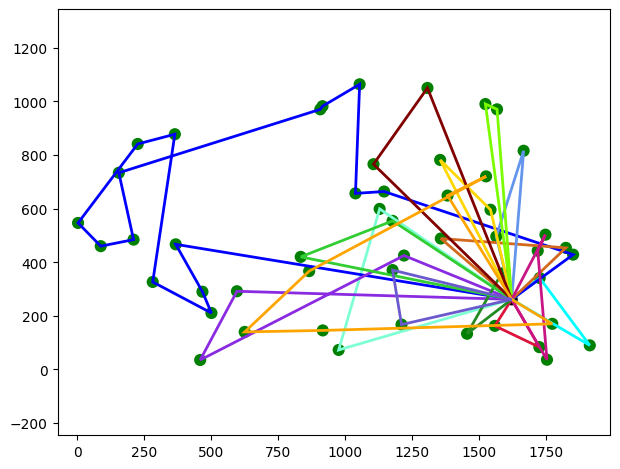

In [14]:
from matplotlib import pyplot as plt, patches
from matplotlib.path import Path

%matplotlib inline
color_index = 0


def generate_color():
    global color_index
    colors =  (
      'aqua',
      'aquamarine',
      'blue',
      'blueviolet',
      'chocolate',
      'cornflowerblue',
      'crimson',
      'forestgreen',
      'gold',
      'lawngreen',
      'limegreen',
      'maroon',
      'mediumvioletred',
      'orange',
      'slateblue',
      'tomato'
    )
    out = colors[color_index]
    color_index = (color_index + 1) % len(colors)
    return out


plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1, 1)

tractor_to_route_dict = dict()
tractor_to_route_color_dict = dict()
field_to_marker_dict = dict()

for field in problem.field_list:
    field_to_marker_dict[field.name] = patches.Circle((field.location.X, field.location.Y), radius=20, color='green')
    ax.add_patch(field_to_marker_dict[field.name])

for barn in problem.barn_list:
    circle = patches.Circle((barn.location.X, barn.location.Y), radius=20, color='black')
    ax.add_patch(circle)

for tractor in problem.tractor_list:
    verts = [(tractor.barn.location.X, tractor.barn.location.Y)]

    codes = [
     Path.MOVETO
    ]
    path = Path(verts, codes)

    color = generate_color()

    tractor_to_route_color_dict[tractor.name] = color

    tractor_to_route_dict[tractor.name] = patches.PathPatch(path, facecolor=color, lw=2)
    ax.add_patch(tractor_to_route_dict[tractor.name])


def update_routes(solution):
    for tractor in solution.tractor_list:
        # Select the current route
        route = tractor_to_route_dict[tractor.name]

        # Change color of all fields belonging to this route
        for field in tractor.field_list:
            field_to_marker_dict[field.name].color = tractor_to_route_color_dict[tractor.name]

        # Set the first point for tractor at the starting barn point
        verts = [(tractor.barn.location.X,tractor.barn.location.Y)]
        codes = [Path.MOVETO]

        # Add the other points to the path
        verts.extend(map(lambda field: (field.location.X,field.location.Y), tractor.field_list))
        for i in range(len(verts)-1):
            codes.append(Path.LINETO)

        # Close the loop, back to the barn
        # locations.append(locations[0])
        verts.append(verts[0])
        codes.append(Path.LINETO)

        path = Path(verts, codes)

        route = patches.PathPatch(path, edgecolor=tractor_to_route_color_dict[tractor.name], facecolor="none", lw=2)
        ax.add_patch(route)
        fig.canvas.draw()


update_routes(final_solution)
ax.axis('equal')
plt.show()

In [15]:
for tractor in final_solution.tractor_list:
    # Select the current route
    route = tractor_to_route_dict[tractor.name]

    # Change color of all fields belonging to this route
    for field in tractor.field_list:
        field_to_marker_dict[field.name].color = tractor_to_route_color_dict[tractor.name]

    verts = [(tractor.barn.location.X, tractor.barn.location.Y)]
    verts.extend(map(lambda field: (field.location.X, field.location.Y), tractor.field_list))

    print(tractor.name)
    print(verts)

1
[(1620.4455330765672, 261.1671992274137), (1911.818793719506, 89.62042583469486), (1724.8706746105795, 340.9813374632389)]
2
[(1620.4455330765672, 261.1671992274137), (1127.6371461526624, 598.856840648718), (974.7380929969813, 72.47230365916766)]
3
[(1620.4455330765672, 261.1671992274137), (366.65774859308743, 466.6559108702951), (466.38535873670213, 289.72313076667524), (499.8847436421701, 210.37497465294894), (280.8619402227111, 326.2133792336533), (363.44195949580944, 877.518839012256), (224.780708667146, 841.123080719613), (2.193070264387866, 546.4294820839148), (86.8041762341101, 459.7985463044889), (209.28200634178796, 484.1826414682953), (154.37552580231545, 733.6610815583231), (906.041870953757, 970.3433964942333), (914.4629736660016, 982.0795142699544), (1052.9539640604958, 1063.8490055230236), (1037.4112559753164, 656.7915617968397), (1144.274487377981, 663.6916634954994), (1849.606169723724, 428.16270742966776)]
4
[(1620.4455330765672, 261.1671992274137), (1218.56482712008